# Forecasting Air Quality in Beijing
Capstone Project for Springboard Data Science Bootcamp

Tamara Monge

## Section 4: Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

import itertools
import warnings

# Classical Stats Modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prophet Model
from fbprophet import Prophet

# Supervised Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score, mean_squared_error  
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

/Users/tami/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import cleaned dataset
df = pd.read_csv('persistence/cleaned_data_2018-06-19.csv', parse_dates=True, index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41757 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 7 columns):
pm25          41757 non-null float64
dewp          41757 non-null int64
temp          41757 non-null float64
pres          41757 non-null float64
wind_speed    41757 non-null float64
snow_hours    41757 non-null int64
rain_hours    41757 non-null int64
dtypes: float64(4), int64(3)
memory usage: 2.5 MB


In [3]:
# Extract time series of interest
pm25 = df['pm25']

In [4]:
# Initialize list to hold metrics
models = []

In [5]:
# Defining some functions for later
def forecast_bias(y_truth, y_pred):
    '''Compute mean forecasting bias'''
    bias = np.mean(y_truth - y_pred)
    return bias

In [6]:
def get_performance_metrics(model_name, y_truth, y_pred):
    '''Build a dictionary of regression model performance metrics: R2, MSE, and Bias'''
    metrics = {}
    metrics = {'Model': model_name, 'R2': r2_score(y_truth, y_pred), 
               'MSE': mean_squared_error(y_truth, y_pred), 
               'Bias': forecast_bias(y_truth, y_pred)}
    return (metrics)

### 1. Seasonal Autoregressive Integrated Moving Average Model: SARIMA

The figures from Section 3 suggest the following parameters for a non-seasonal ARIMA model:
- p  =  1,  because PACF first crosses significance line after lag-1
- d  =  0,  because original series is stationary
- q  =  0,  because ACF decays gradually 

In addition, we see a seasonal component to the ACF and PACF for s = 24. Therefore we will try a Seasonal ARIMA model.
- P = 1, because ACF is positive at lag-s
- D = 1, because original series, ACF, and PACF show a 24-hour period
- Q = 0, because ACF is not negative at lag-s
- s = 24, because of 24-lag period

Our best guess for the optimal parameters is SARIMAX (1,0,0)(1,1,0,24).

Let's see if an exhaustive gridsearch confirms this or finds other parameters to be optimal. 

** Select optimal parameters **

In [7]:
# Split into Train and Evaluation sets, retaining temporal order of observations
### This split is for the Seasonal ARIMA model ONLY ###
size = int(len(pm25)*0.7)
train, test = pm25[0:size], pm25[size:len(pm25)]

In [8]:
# # Gridsearch manually to select the optimal parameter values for SARIMAX
# # scoring metric = AIC measures trade-off between goodness of fit of the model and the complexity of the model. 
# # Lowest score is best.

# # Define grid to search for p, d, and q
# p = range(0,3)
# d = q = range(0, 2)
# pdq = list(itertools.product(p,d,q))

# # Define grid to search for P, D, and Q
# seasonal_pdq = [(i[0], i[1], i[2], 24) for i in list(itertools.product(p,d,q))]

# # Grid search
# warnings.filterwarnings("ignore")
# start = time()
# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# model = None
# best_model = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try: 
#             model = SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
#             results = model.fit()
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = param_seasonal
#                 best_model = model
#         except:
#             continue  # some parameter combinations may cause numerical misspecification which will throw exceptions. catch and ignore these combinations. 
# print(time()-start)

# print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic)) 

** Run model **

/Users/tami/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                               pm25   No. Observations:                29229
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 24)   Log Likelihood             -135117.972
Date:                            Mon, 25 Jun 2018   AIC                         270249.943
Time:                                    20:49:41   BIC                         270307.924
Sample:                                01-02-2010   HQIC                        270268.570
                                     - 07-21-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8977      0.009     94.938      0.000       0.879       0.916
ar.L2          0.0464      0.010   

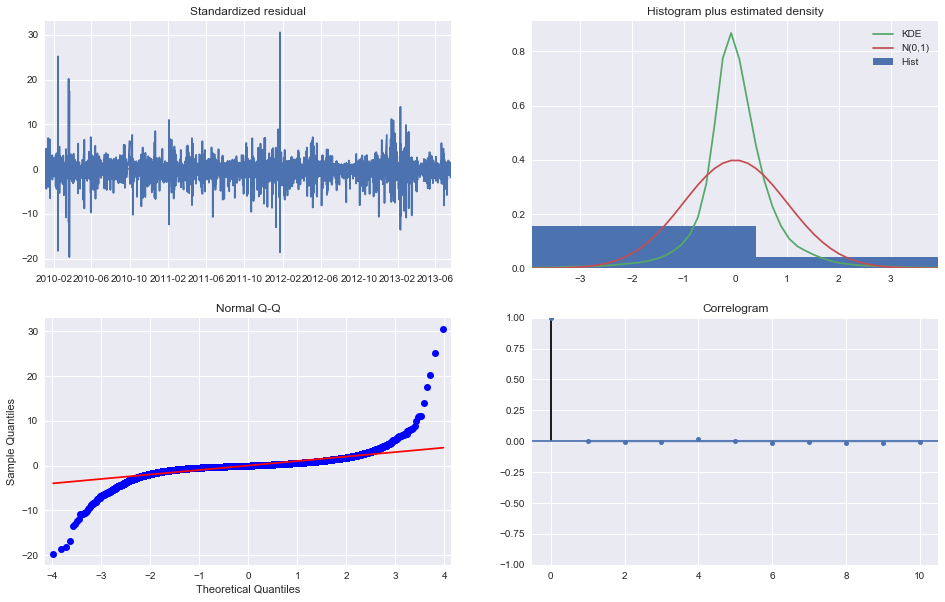

In [10]:
model = SARIMAX(train, order=(2,0,1), seasonal_order=(2,1,1,24), 
                enforce_stationarity=False, enforce_invertibility=False)  #order=best_pdq, seasonal_order=best_seasonal_pdq,
results = model.fit()
print(results.summary());
results.plot_diagnostics(figsize=(16,10));
plt.savefig('../figures/sarima_figures.png');

- The histogram in the top right plot indicates that the residuals are not truly normally distributed. 

Let's try a different statistical modeling technique.

### 2. Additive Regression Model: Prophet 

** Prepare data **

In [11]:
# Prepare the data for prophet ingestion
df_prophet = df.reset_index()[['date', 'pm25']][:-8760] #hold out last year for final out-of-sample test
df_prophet.columns = ('ds', 'y')

** Fit model**

In [12]:
# Instantiate a new prophet object
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive')
# Fit the model
m.fit(df_prophet)

** Predict**

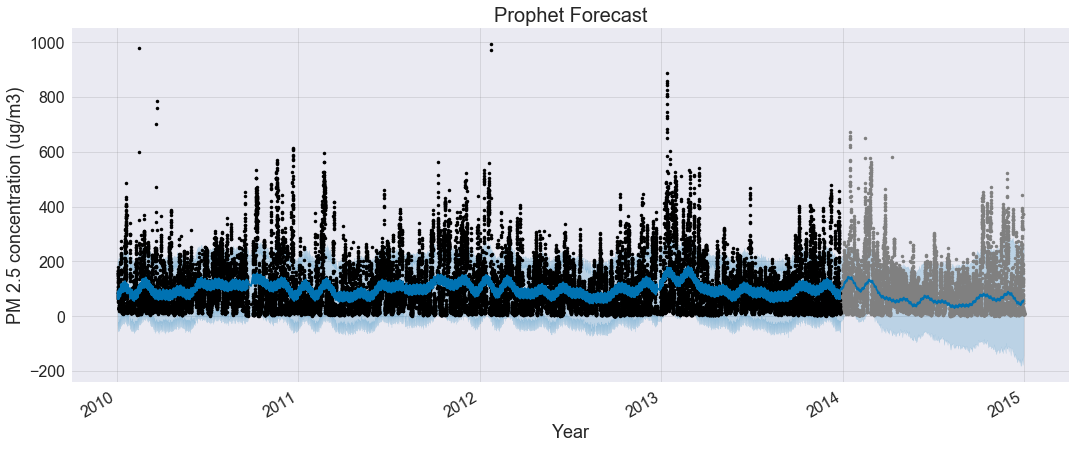

In [13]:
# Specify days to be predicted
future = m.make_future_dataframe(periods=369)
# Forecast
forecast = m.predict(future)
# Plot the forecast
fig1 = pm25[-8760:].plot(figsize=(15,6), linestyle='none', marker='.', color='gray', fontsize=16)
m.plot(forecast, ax=fig1)
plt.xlabel('Year', fontsize=18)
plt.ylabel('PM 2.5 concentration (ug/m3)', fontsize=18)
plt.title('Prophet Forecast', fontsize=20)
plt.savefig('../figures/prophet_forecast.png');

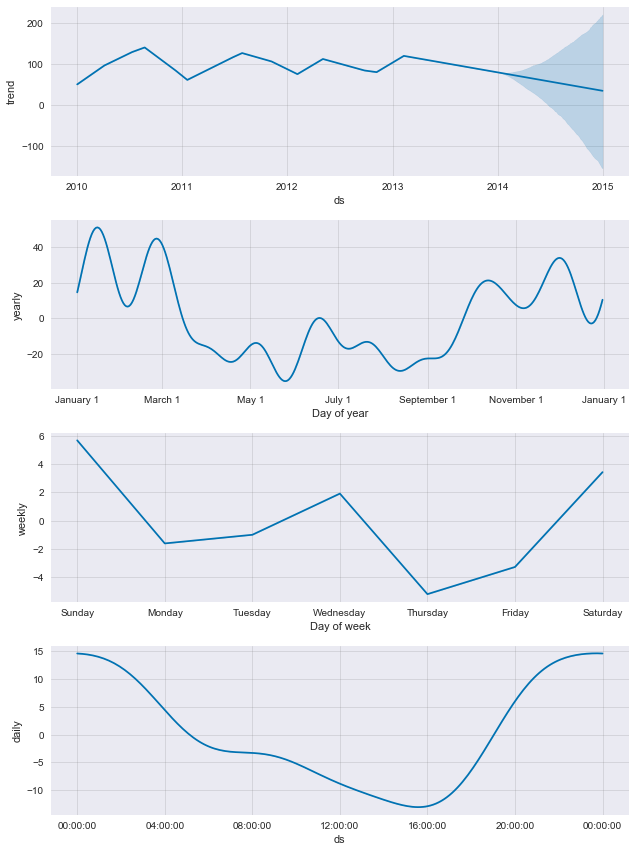

In [14]:
# Plot the forecast components
m.plot_components(forecast)
plt.savefig('../figures/prophet_forecast_components.png');

In [15]:
# Extract the prediction and evaluate against daily average
proph = get_performance_metrics('Prophet', pm25['2014'].resample('D', how='mean'), forecast.set_index('ds')['2014']['yhat'].resample('D', how='mean'))
models.append(proph)

/Users/tami/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


### 3. Supervised Regression Models

** Prepare Features **

In [16]:
# Prepare lag features out to one week #24-hours  
for i in range(1,721):
    pm25_lag_feat = "pm25_lag %s" %i
    dewp_lag_feat = "dewp_lag %s" %i
    df[pm25_lag_feat]  = df['pm25'].diff(periods=-i)
    df[dewp_lag_feat]  = df['dewp'].diff(periods=-i)

# Remove index 
df.reset_index(drop=True, inplace=True)

# Assign X and y
y = df['pm25'].iloc[:-720] #-24 
X = df.drop(['pm25'], axis=1).iloc[:-720]

# Standardize the data
Xscaled = scale(X)

# Hold out last year of data for final out-of-sample test 
X_test = Xscaled[-8760:]
y_test = y[-8760:]

# Split first four years of data into training and evaluating sets
X_train, X_eval, y_train, y_eval = train_test_split(Xscaled[:-8760], y[0:-8760], train_size=0.7, random_state=42)

** Fit and Predict**

In [17]:
linreg = get_performance_metrics('Linear Regression', y_eval, LinearRegression(fit_intercept=True, copy_X=True)
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(linreg)

In [18]:
knn = linreg = get_performance_metrics('KNN Regression', y_eval, KNeighborsRegressor()
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(knn)

In [19]:
sgd = get_performance_metrics('Stochastic Gradient Descent', y_eval, SGDRegressor(random_state=42)
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(sgd)

In [20]:
dtr = get_performance_metrics('Decision Tree', y_eval, DecisionTreeRegressor()
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(dtr)

In [21]:
rfr = get_performance_metrics('Random Forest', y_eval, RandomForestRegressor(random_state=42)
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(rfr)

In [76]:
mlp = get_performance_metrics('Multi-Layer Perceptron', y_eval, MLPRegressor(random_state=42)
                                        .fit(X_train, y_train)
                                        .predict(X_eval))
models.append(mlp)

### 4. Evaluation


In [77]:
df_models = pd.DataFrame(models).set_index('Model')
df_models = df_models[['R2', 'MSE', 'Bias']]
df_models.sort_values('R2', ascending=False)

# R$^2$ Score (coefficient of determination):  best possible score is 1.0, highest value is best.
# MSE:  lowest value is best.

,R2,MSE,Bias
Model,,,
Multi-Layer Perceptron,9.978069e-01,1.829706e+01,-2.047060e-01
Multi-Layer Perceptron,9.965029e-01,2.917688e+01,-8.442573e-01
Random Forest,9.939454e-01,5.051404e+01,1.793722e+00
Decision Tree,9.844665e-01,1.295971e+02,1.623916e+00
KNN Regression,9.728387e-01,2.266082e+02,6.685461e-01
Linear Regression,9.307071e-01,5.781160e+02,2.130997e-01
Prophet,-2.579001e-02,6.833282e+03,2.863110e+01
Stochastic Gradient Descent,-2.864155e+16,2.389585e+20,6.891360e+07


**Multi-layer perceptron wins!**

### Forecasting

In [78]:
# Fit final model
final_model = MLPRegressor(random_state=42).fit(Xscaled[:-8760], y[:-8760]) #fit on all data except final year

# Make prediction on out-of-sample (test) data
y_pred = final_model.predict(X_test)
get_performance_metrics('Final Model', y_test, y_pred)

{'Bias': -1.9339784161899158,
 'MSE': 413.7572003184589,
 'Model': 'Final Model',
 'R2': 0.95353795271937725}

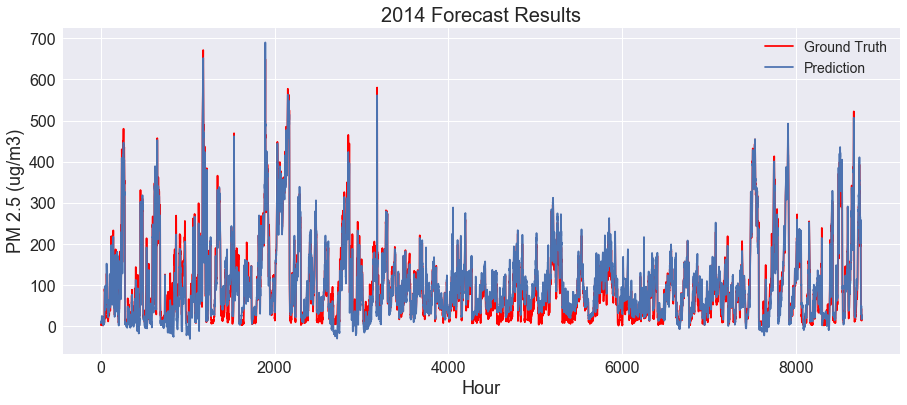

In [80]:
# Plot
fig = plt.figure(figsize=(15,6))
y_test.reset_index()['pm25'].plot(color='red')
pd.Series(y_pred).plot(fontsize=16)
plt.title('2014 Forecast Results', fontsize=20)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('PM 2.5 (ug/m3)', fontsize=18)
plt.legend(['Ground Truth', 'Prediction'], fontsize=14);
plt.savefig('../figures/forecast_results.png');

## Results

- On out-of-sample data, the final model receives an **R$^2$ score of 95.4%**! This is impressive for a statistical (non-physical) model. 
- While the model tends to underforecast the PM 2.5 concentration by 1.9 $\mu$g/m$^3$, this is still only a **2% bias** of the average concentration of 98.6 $\mu$g/m$^3$. 


- ** Recommendation to Client: ** For fast, accurate forecasting that is less computationally expensive than traditional physics-based air quality models, deploy the multi-layer-perceptron (neural network) model developed here. In addition to providing high-quality forecasts, it can also quickly learn on new observations. 